# Data Cleaning and Feature Engineering

## Import Data

In [275]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.model_selection import train_test_split


In [276]:
# Import data

#Import train data
train_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/train.csv'
df_train = pd.read_csv(train_data_url)

#Import test data
test_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/test.csv'
df_test = pd.read_csv(test_data_url)


## Data Cleaning

### Data Removal

Based on the exploritory data analysis, attributes that have a high amount of missing data and low impact shall be removed from the data set.

In [277]:
X_train = df_train.drop(columns=['PoolQC','MiscFeature','Alley','Fence','Id'])

### Cleaning Housing SqFt

The EDA confirms the assumption that larger houses are correlated to highter prices. This section reviews all attributes that measure the size of the house.

The basement area is not counted as basesments may not be used in assessing property value. The correlation between 'TotalBsmtSF' and price may be due to the correlation of the size of the foundation to the size of the first floor. Keeping 'TotalBsmtSF' in the model may lead to colinearity.

In [278]:
# Removal of 'TotalBsmtSf'
X_train = X_train.drop(columns=['TotalBsmtSF'])

Since square-footage of the house is highly correlated to its price, lets calculate

The data set breaks sqft and room data into basement, first floor, and seccond floor. We believe combining first and second floor room and sqft data into a single dimension will reduce the risk of colineiarity of two attributes being in the model and increase the power of the attribute.

We will leave the basement data seperate as we do not understand if the basement attributes are allowed to be used in housing assessments.

In [279]:
# Combine SqFt
X_train['TotSqFt'] = X_train['1stFlrSF'] + X_train['2ndFlrSF']
X_train = X_train.drop(columns=['1stFlrSF','2ndFlrSF'])

## Per the data documentation, PECIAL NOTES:
"There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

We thus remove the houses whose GrLivArea is greater than or equal to 4000 square feet.

In [282]:
X_train.drop(X_train[X_train.GrLivArea >= 4000].index, inplace=True)

In [283]:
X_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3Ssn

In [284]:
#Describe numerical variables
NumDataSet = X_train.select_dtypes(exclude='O')
#Describe categorical variables
CatDataSet = X_train.select_dtypes(include='O')
Categorical_Cols = CatDataSet.columns.tolist()
Categorical_Cols

Numerical_Cols = NumDataSet.columns.tolist()
Numerical_Cols 
#Within categorical variables, there are several categories that are not 
#purely nominal/unordered but insteted are ordered categories - In other
#words, they are ordinal but have text values, not numerical values. We separate
#these into a new category
Ordered_Category = CatDataSet[['ExterQual','ExterCond','BsmtQual','BsmtCond',
                   'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']].copy()
for i in Ordered_Category:
    print(Ordered_Category[i].value_counts())
    
#Remove these columns from the categorical dataset, which will now include only
#unordered categories
CatDataSet = CatDataSet.drop(['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'], axis = 'columns')


#4.2.2 Convert all cateogrical values to numeric values
#For ordered category data, use the ordinal encoder from sklearn.
#Given a dataset with unique features, we let the encoder find the unique values per feature and transform the data to an ordinal encoding.
Ordered_Category['ExterQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['ExterCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['HeatingQC'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['KitchenQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['FireplaceQu'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
NumDataSet['GarageYrBlt'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['LotFrontage'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['MasVnrArea'].replace(to_replace=[np.nan], value=[0], inplace=True)


TA    906
Gd    487
Ex     49
Fa     14
Name: ExterQual, dtype: int64
TA    1278
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
TA    649
Gd    618
Ex    117
Fa     35
Name: BsmtQual, dtype: int64
TA    1307
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
Ex    737
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64
TA    735
Gd    586
Ex     96
Fa     39
Name: KitchenQual, dtype: int64
Gd    378
TA    312
Fa     33
Ex     23
Po     20
Name: FireplaceQu, dtype: int64
TA    1307
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
TA    1322
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


C:\Users\djwei\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [285]:
#Import LabelEncoder to code categorical variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [286]:
#For categorical data, use LabelEncoder to categorize the variables.
for col in CatDataSet:
    i = CatDataSet.columns.get_loc(col)
    CatDataSet.iloc[:,i] = CatDataSet.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [287]:
# glue data sets together
X_train2 = pd.concat((CatDataSet, Ordered_Category, NumDataSet), axis=1, join='inner')

In [288]:
#See if there are any nulls left.
X_train2.isnull().sum().sort_values(ascending = False).head(20)

TotSqFt          0
BsmtExposure     0
BsmtFinType2     0
Heating          0
CentralAir       0
Electrical       0
Functional       0
GarageType       0
GarageFinish     0
PavedDrive       0
SaleType         0
SaleCondition    0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
HeatingQC        0
BsmtFinType1     0
Foundation       0
SalePrice        0
dtype: int64

In [289]:
X_train2['SalePrice'] = np.log(X_train2['SalePrice'])
X_test2['SalePrice'] = np.log(X_test2['SalePrice'])

In [290]:
corr_matrix = X_train2.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.819240
TotSqFt          0.729421
GrLivArea        0.718844
GarageCars       0.680408
GarageArea       0.655211
BsmtQual         0.615224
FullBath         0.590919
YearBuilt        0.588977
YearRemodAdd     0.568986
FireplaceQu      0.546552
TotRmsAbvGrd     0.533446
Fireplaces       0.487126
MasVnrArea       0.425946
Foundation       0.412103
BsmtFinSF1       0.382710
GarageQual       0.365490
GarageCond       0.358917
CentralAir       0.353708
GarageYrBlt      0.351023
WoodDeckSF       0.330573
OpenPorchSF      0.327038
HalfBath         0.311191
PavedDrive       0.306194
Electrical       0.295600
BsmtCond         0.276638
SaleCondition    0.260785
LotArea          0.258945
BsmtFullBath     0.238851
BsmtUnfSF        0.223248
                   ...   
RoofMatl         0.085922
MoSold           0.062231
Street           0.057595
3SsnPorch        0.056065
PoolArea         0.040679
LandSlope        0.040113
LandContour      0.031806
BsmtFinSF2  

In [291]:
#Show a correlation matrix with numbers
corrs = X_train2.corr('spearman')

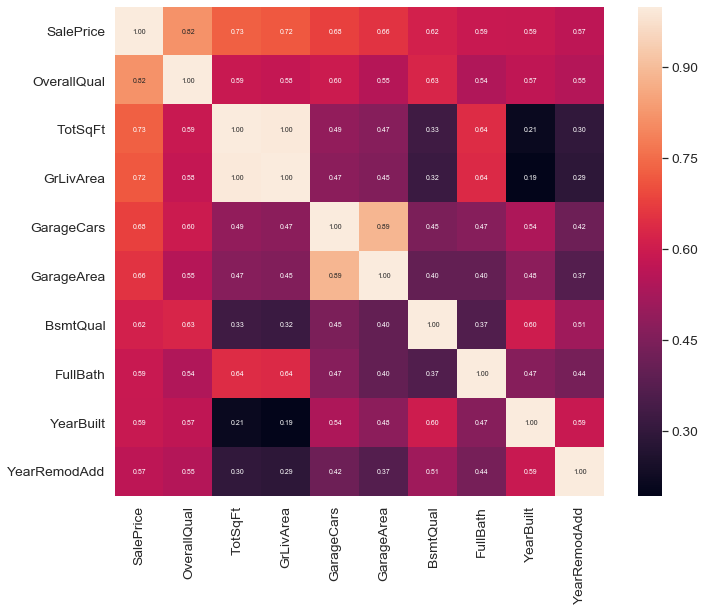

In [292]:
#Filter out 10 highest correlated categories
corr_num = 10
corr_cols = corr_matrix.nlargest(corr_num,'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(X_train2[corr_cols].values.T)
sns.set(font_scale=1.25)
fig,ax = plt.subplots(figsize=(12,9))
hm = sns.heatmap(corr_mat_sales, cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':7}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)

In [316]:
LR1Xtrain = pd.DataFrame(data=X_train2,columns=['OverallQual', 'TotSqFt', 'GrLivArea', 'GarageCars', 'GarageArea', 'BsmtQual', 'FullBath', 'YearBuilt', 'YearRemodAdd'])
LR1Ytrain = pd.DataFrame(data= X_train2,columns=['SalePrice'])

In [317]:
X_train, X_test, y_train, y_test = train_test_split(LR1Xtrain, LR1Ytrain,
                                                    test_size=0.25,random_state=2)

X_train.shape, X_test.shape

((1092, 1), (364, 1))

In [318]:
ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## Standard Linear Regression

In [319]:
lr = LinearRegression()

In [320]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [321]:
y_predict_test = lr.predict(X_test_scaled)

In [322]:
print("\nTesting RMSE: ")
print("Root Mean Square Error :",mean_squared_error(y_test, y_predict_test)**0.5)


Testing RMSE: 
Root Mean Square Error : 0.23103368019246548


## Ridge Regression

In [301]:
ridge = RidgeCV(alphas=np.linspace(1, 200, 100))
ridge_model = ridge.fit(X_train_scaled, y_train)
y_predict_test = ridge_model.predict(X_test_scaled)
print("\nTesting RMSE: ")
print("Root Mean Square Error :",mean_squared_error(y_test, y_predict_test)**0.5)


Testing RMSE: 
Root Mean Square Error : 0.1572975702269465


Text(0.5, 1.0, 'Ridge Predictions of Sale Price vs Actual Sale Price')

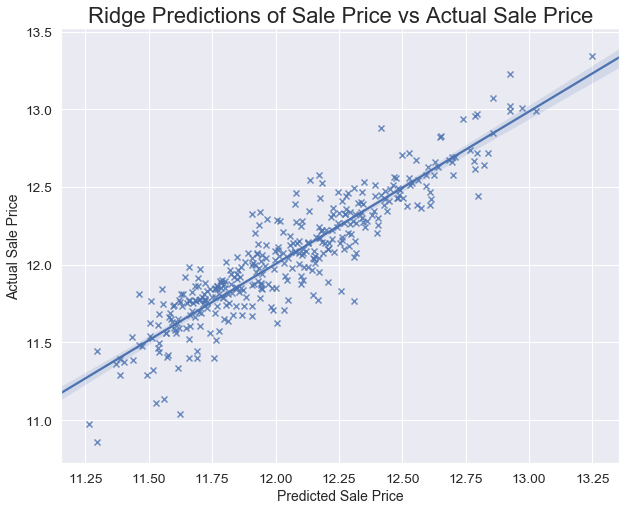

In [302]:
# Create scatterplot to show predicted values versus actual values
ridge_preds = ridge.predict(X_test_scaled)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train_scaled, x=ridge_preds, y=np.ravel(y_test), marker='x')
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Ridge Predictions of Sale Price vs Actual Sale Price', fontsize=22)

## Elasticnet Regression

In [303]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_ratio = 0.5
enet = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, max_iter=5_000)
enet = enet.fit(X_train_scaled, np.ravel(y_train))

In [304]:
y_predict_test = enet.predict(X_test_scaled)
print("\nTesting RMSE: ")
print("Root Mean Square Error :",mean_squared_error(y_test, y_predict_test)**0.5)


Testing RMSE: 
Root Mean Square Error : 0.15752739370092603


Text(0.5, 1.0, 'ElasticNet Predictions of Sale Price vs Actual Sale Price')

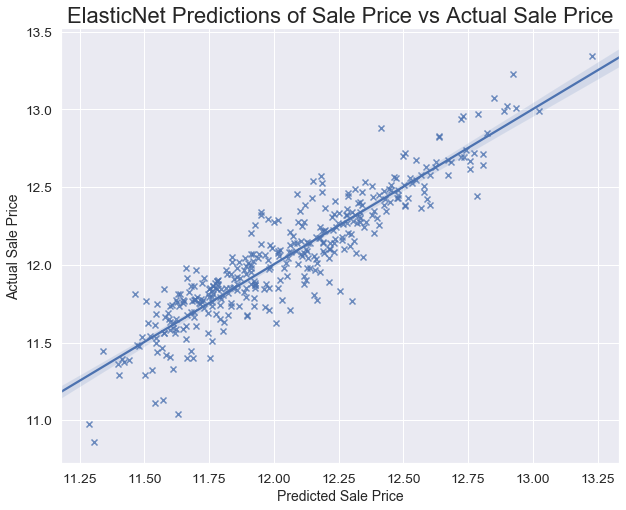

In [305]:
# Create scatterplot to show predicted values versus actual values
enet_preds = enet.predict(X_test_scaled)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train_scaled, x=enet_preds, y=np.ravel(y_test), marker='x')
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('ElasticNet Predictions of Sale Price vs Actual Sale Price', fontsize=22)

## Lasso Regression

In [306]:
lasso = LassoCV(n_alphas=100)
lasso.fit(X_train_scaled,np.ravel(y_train))

C:\Users\djwei\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [307]:
y_predict_test = lasso.predict(X_test_scaled)
print("\nTesting RMSE: ")
print("Root Mean Square Error :",mean_squared_error(y_test, y_predict_test)**0.5)


Testing RMSE: 
Root Mean Square Error : 0.1573824701667759


Text(0.5, 1.0, 'ElasticNet Predictions of Sale Price vs Actual Sale Price')

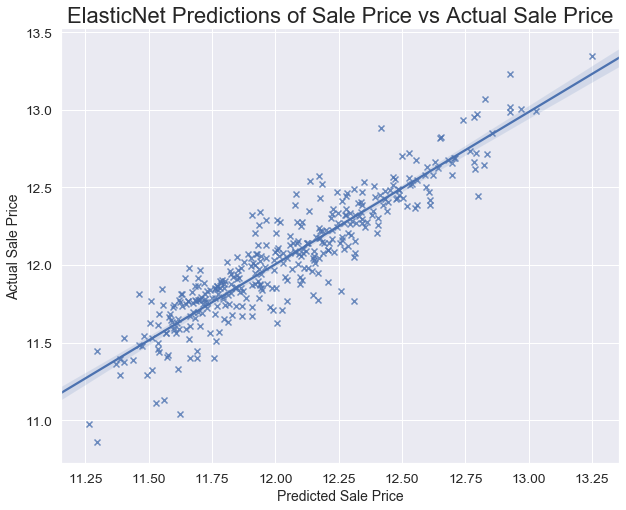

In [308]:
# Create scatterplot to show predicted values versus actual values
lasso_preds = lasso.predict(X_test_scaled)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train_scaled, x=lasso_preds, y=np.ravel(y_test), marker='x')
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('ElasticNet Predictions of Sale Price vs Actual Sale Price', fontsize=22)

## Gradient Boost Regression

In [309]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, random_state =85)

In [310]:
gbr.fit(X_train_scaled,np.ravel(y_train))
y_predict_test = gbr.predict(X_test_scaled)
print("\nTesting RMSE: ")
print("Root Mean Square Error :",mean_squared_error(np.ravel(y_test), y_predict_test)**0.5)


Testing RMSE: 
Root Mean Square Error : 0.16956705915528444


Text(0.5, 1.0, 'Gradient Boost Regression Predictions of Sale Price vs Actual Sale Price')

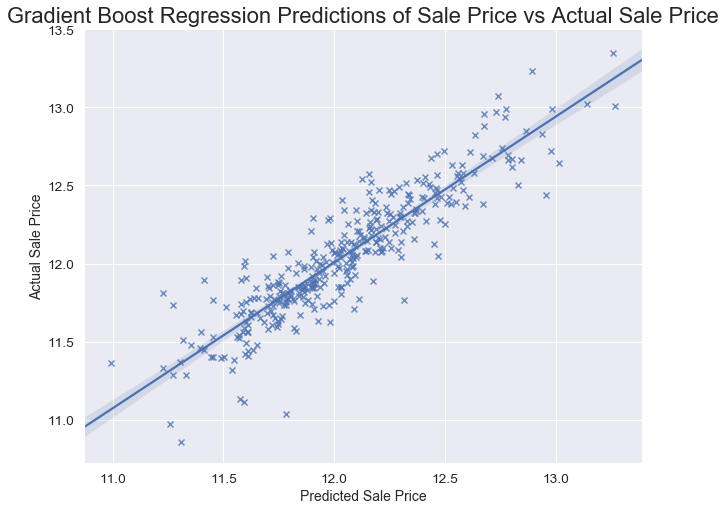

In [311]:
# Create scatterplot to show predicted values versus actual values
gbr_preds = gbr.predict(X_test_scaled)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train_scaled, x=gbr_preds, y=np.ravel(y_test), marker='x')
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Gradient Boost Regression Predictions of Sale Price vs Actual Sale Price', fontsize=22)

## XGBoost Regression

In [312]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3000)

In [313]:
xgboost.fit(X_train_scaled,y_train)
y_predict_test = xgboost.predict(X_test_scaled)
print("\nTesting RMSE: ")
print("Root Mean Square Error :",mean_squared_error(y_test, y_predict_test)**0.5)


Testing RMSE: 
Root Mean Square Error : 0.1641459158558838


Text(0.5, 1.0, 'Gradient Boost Regression Predictions of Sale Price vs Actual Sale Price')

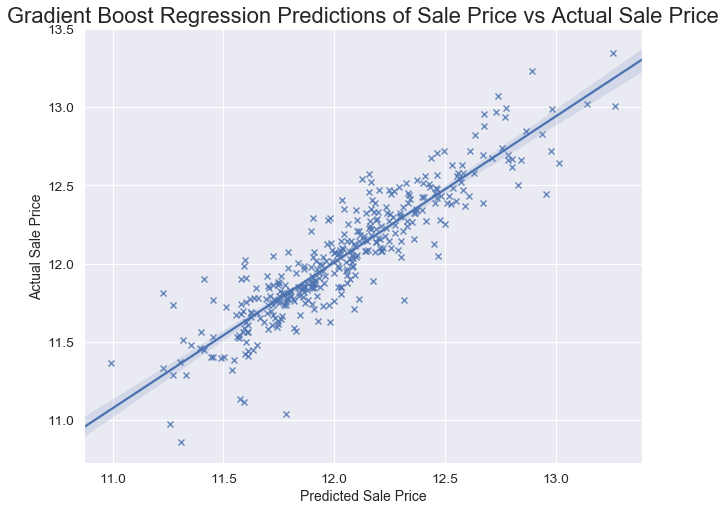

In [315]:
# Create scatterplot to show predicted values versus actual values
xgb_preds = gbr.predict(X_test_scaled)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train_scaled, x=xgb_preds, y=np.ravel(y_test), marker='x')
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Gradient Boost Regression Predictions of Sale Price vs Actual Sale Price', fontsize=22)